<a href="https://colab.research.google.com/github/seanzhu815/415/blob/main/415assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#import modules

In [99]:
# Load Packages

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt




#Part1

##a&b

In [100]:
# Load Data
df = pd.read_csv('drive/MyDrive/MGTF415/data-crsp-lecture-4.csv')

# Rename Colums
df.columns = ['permno', 'date', 'price', 'adjFactor']

# Create Ticker Variable
conditions = [
    (df['permno'] == 90878),
    (df['permno'] == 77178)]
choices = ['VTI', 'QCOM']
df['ticker'] = np.select(conditions, choices)

## c

In [101]:
# Pivot the Table
df = df.pivot(index = 'date', columns = 'ticker', 
                values = ['price', 'adjFactor']).reset_index()
df.columns = list(map("".join, df.columns))

##d

In [102]:
# Convert date variable to datetime
df['date'] = pd.to_datetime(df['date'])


##e

In [103]:
# Drop empty prices
df = df[(df['priceQCOM'].notna()) & (df['priceVTI'].notna())]

# Adjust for splits
df['priceVTI'] = df['priceVTI'] / df['adjFactorVTI']
df['priceQCOM'] = df['priceQCOM'] / df['adjFactorQCOM'] 



##f

In [104]:
# Target allocation
targetVTI = 0.70

# Initial prices: 71.410005 (VTI) and 37.6600 (QCOM)

# Initial number of shares (chosen to start at target allocation)
df['sharesVTI'] = 10
df['sharesQCOM'] = 8

##g

In [105]:
# Actual allocation
df['actualVTI'] = df['priceVTI'] * df['sharesVTI'] / (df['priceVTI'] * df['sharesVTI'] + df['priceQCOM'] * df['sharesQCOM'])

# Tracking error
df['error'] = df['actualVTI'] - targetVTI

##h

In [106]:
# Tracking error threshold (10% for lecture, 3% for homework)
threshold = 0.1

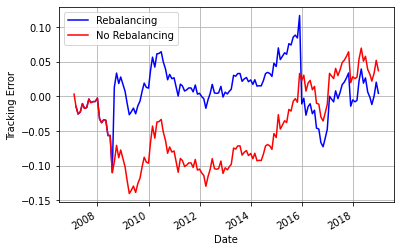

In [107]:

# Required amount to buy to eliminate tracking error
df['buy'] = - df['error'] * (df['priceVTI'] * df['sharesVTI'] + df['priceQCOM'] * df['sharesQCOM']) / df['priceVTI']
# Store error without any rebalancing
errorNoRebalance = df['error']
errorNoRebalance.index = df['date']

# Sort by date
df = df.sort_values(by = 'date')

# List of dates to loop through (drop first date)
dates = list(dict.fromkeys(df['date']))
dates.remove(min(dates))

# Loop through dates, rebalancing as needed
for i in dates:
    
    # Define lagged shares
    df['lagSharesVTI'] = df['sharesVTI'].shift(1)
    df['lagSharesQCOM'] = df['sharesQCOM'].shift(1)
    
    # Running allocation based on last period's shares
    df['actualVTI'] = df['priceVTI'] * df['lagSharesVTI'] \
        / (df['priceVTI'] * df['lagSharesVTI'] + df['priceQCOM'] * df['lagSharesQCOM'])
    
    # Running tracking error
    df['error'] = df['actualVTI'] - targetVTI
    
    # Running required amount to buy
    df['buy'] = - df['error'] * (df['priceVTI'] * df['lagSharesVTI'] + df['priceQCOM'] * df['lagSharesQCOM']) \
        / df['priceVTI']
    
    # Check if error exceeds threshold
    error = np.mean(df.loc[df.date == i, 'actualVTI']) - targetVTI
    if abs(error) > threshold:
        
        # Replace shares with required amount to buy
        df.loc[df.date == i, 'sharesVTI'] =  \
            df.loc[df.date == i, 'lagSharesVTI'] + df.loc[df.date == i, 'buy']
        df.loc[df.date == i, 'sharesQCOM'] =  \
            df.loc[df.date == i, 'lagSharesQCOM'] - df.loc[df.date == i, 'buy'] * df['priceVTI'] / df['priceQCOM']
       
    # Forward-fill shares based on new value
    df.loc[df.date >= i, 'sharesVTI'] = np.mean(df.loc[df.date == i, 'sharesVTI'])
    df.loc[df.date >= i, 'sharesQCOM'] = np.mean(df.loc[df.date == i, 'sharesQCOM'])
    

# Plot resulting tracking error over time
errorRebalance = df['error']
errorRebalance.index = df['date']

fig = plt.figure()

ax1 = errorRebalance.plot(color='blue', grid=True, label='Rebalancing')
ax2 = errorNoRebalance.plot(color='red', grid=True, label='No Rebalancing')

ax1.legend(loc=1)
ax2.legend(loc=2)

ax1.set_ylabel('Tracking Error')
ax1.set_xlabel('Date')

plt.show()

fig.savefig("tracking-error-10.png")